# Multi Stage Prediction 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam


In [24]:
# Load Data

daily_data = pd.read_csv("daily_merged_data(no_lags).csv")
monthly_data = pd.read_csv("merged_monthyl_data.csv")
yearly_data = pd.read_csv("merged_Yearly_data,csv")


In [25]:
daily_data.head()

,date,loadConsumption,DailyPrecipitation,MaxHourlyPrecipitation,HDMaxPrecipitation,DailyMeanTemperature,HourlyMinTemperature,HDMinTemperature,HourlyMaxTemperature,HDMaxTemperature,DailyMeanWindspeed,MaxHourlyMeanWindspeed,HDMaxMeanWindspeed,MinHourlyMeanWindspeed,HDMinMeanWindspeed,Month,Year,Week,WeekKey,day_of_week
0,2015-01-01,275667.0,-0.1,-0.1,1,3.0,10,5,4.7,24,5.4,8.0,24,4.0,1,1,2015,1,201501,Thursday
1,2015-01-02,319026.0,4.3,1.7,3,7.3,44,1,10.1,8,6.1,9.0,2,4.0,20,1,2015,1,201501,Friday
2,2015-01-03,313131.0,1.5,0.5,10,3.8,26,17,5.9,1,3.3,5.0,7,1.0,17,1,2015,1,201501,Saturday
3,2015-01-04,296832.0,-0.1,-0.1,1,3.9,-3,21,8.0,13,2.4,3.0,11,2.0,1,1,2015,1,201501,Sunday
4,2015-01-05,350937.0,0.0,0.0,1,2.4,9,11,3.8,24,3.0,5.0,11,1.0,22,1,2015,2,201502,Monday


In [26]:
# Convert datetime columns
daily_data["date"] = pd.to_datetime(daily_data["date"])

daily_data.set_index("date", inplace=True)

In [27]:
# Ensure numerical columns are correctly formatted
yearly_data["Population"] = yearly_data["Population"].str.replace(',', '').astype(float)

## Stage 1: Yearly Forecasting

In [28]:
# One-Hot Encode PriceComponents
yearly_data = pd.get_dummies(yearly_data, columns=["PriceComponents"], drop_first=True)

In [29]:
# Ensure all rows are printed
pd.set_option('display.max_rows', None)

In [30]:
# Select Features and Target
selected_features = ['Population', 'GDP', 'PriceComponents_TotalPrice', 'OffshoreWindEnergy (MWh)', 'TotalSolarEnergy (MWh)', 'TotalRes(incl.Stat.Transfer) (MWh)']

# Define the feature matrix X and the target variable y.
X_yearly = yearly_data[selected_features]
y_yearly = yearly_data['loadConsumption'] 


In [31]:
# Split the data into training and testing sets
X_train_yearly, X_test_yearly, y_train_yearly, y_test_yearly = train_test_split(X_yearly, y_yearly, test_size=0.2, random_state=42)

# Scale Data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_yearly)
X_test_scaled = scaler.transform(X_test_yearly)

In [32]:
# Train MOdel
# Train Model
model_yearly = RandomForestRegressor(n_estimators=100, random_state=42)
model_yearly.fit(X_train_scaled, y_train_yearly)
y_pred_yearly = model_yearly.predict(X_test_scaled)


In [33]:
# Store yearly predictions in monthly dataset
monthly_data["Predicted_Yearly_Load"] = np.repeat(
    model_yearly.predict(scaler.transform(X_yearly)),
    len(monthly_data) // len(yearly_data)
)[:len(monthly_data)]

In [34]:
# Generate yearly predictions
predicted_yearly_load = model_yearly.predict(scaler.transform(X_yearly))

# Expand yearly predictions to match daily data size
num_days_per_year = len(daily_data) // len(yearly_data)
expanded_yearly_load = np.repeat(predicted_yearly_load, num_days_per_year)

# Handle potential size mismatch
if len(expanded_yearly_load) < len(daily_data):
    expanded_yearly_load = np.append(expanded_yearly_load, [expanded_yearly_load[-1]] * (len(daily_data) - len(expanded_yearly_load)))

# Store in daily dataset
daily_data["Predicted_Yearly_Load"] = expanded_yearly_load[:len(daily_data)]

In [35]:
# Compute accuracy metrics
r2 = r2_score(y_test_yearly, y_pred_yearly)
mae = mean_absolute_error(y_test_yearly, y_pred_yearly)
mse = mean_squared_error(y_test_yearly, y_pred_yearly)
# Compute Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_test_yearly - y_pred_yearly) / y_test_yearly)) * 100

print("Accuracy Metrics for the Yearly Prediction Model:")
print(f"R-squared: {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

Accuracy Metrics for the Yearly Prediction Model:
R-squared: 0.9991
Mean Absolute Error (MAE): 93151.2438
Mean Squared Error (MSE): 13647247597.7597
Mean Absolute Percentage Error (MAPE): 0.08%


#### calculate Monthly Change in load consumption

In [36]:
# Compute Monthly Load Change (%)
monthly_data['Load_Change_Percentage'] = monthly_data['loadConsumption'].pct_change()
monthly_data['Load_Change_Percentage'].fillna(0, inplace=True)  # Fill NaN for the first month

# Merge Monthly Load Change into Daily Data
daily_data = daily_data.merge(monthly_data[['Month', 'Load_Change_Percentage']], on='Month', how='left')

## Stage 2: Daily Prediction

In [37]:
daily_data.columns

Index(['loadConsumption', 'DailyPrecipitation', 'MaxHourlyPrecipitation',
       'HDMaxPrecipitation', 'DailyMeanTemperature', 'HourlyMinTemperature',
       'HDMinTemperature', 'HourlyMaxTemperature', 'HDMaxTemperature',
       'DailyMeanWindspeed', 'MaxHourlyMeanWindspeed', 'HDMaxMeanWindspeed',
       'MinHourlyMeanWindspeed', 'HDMinMeanWindspeed', 'Month', 'Year', 'Week',
       'WeekKey', 'day_of_week', 'Predicted_Yearly_Load',
       'Load_Change_Percentage'],
      dtype='object')

In [38]:
daily_data = pd.get_dummies(daily_data, columns=["day_of_week"], drop_first=True)

In [43]:
# Feature Engineering Function
def feature_importance_rfa(X, y):
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X, y)
    feature_importances = pd.Series(model.feature_importances_, index=X.columns)
    feature_importances.sort_values(ascending=False, inplace=True)
    
    # Print feature importances
    #print("Feature Importances (Descending Order):")
    #print(feature_importances)
    
    return feature_importances

In [51]:
## Stage 2: Daily Forecasting

daily_features = daily_data.drop(columns=["loadConsumption"])
daily_target = "loadConsumption"
X_daily = daily_features
y_daily = daily_data[daily_target]

# Compute feature importance
daily_feature_importance = feature_importance_rfa(X_daily, y_daily)
selected_daily_features = list(daily_feature_importance.index[:5]) + ["Predicted_Yearly_Load"] + ['Load_Change_Percentage']
X_daily = X_daily[selected_daily_features]

# Train Daily Model
X_train_daily, X_test_daily, y_train_daily, y_test_daily = train_test_split(X_daily, y_daily, test_size=0.2, random_state=42)
X_train_scaled_daily = scaler.fit_transform(X_train_daily)
X_test_scaled_daily = scaler.transform(X_test_daily)

model_daily = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
model_daily.fit(X_train_scaled_daily, y_train_daily)
y_pred_daily = model_daily.predict(X_test_scaled_daily)

# Evaluate
print("Daily Model Performance:")
print(f"MAE: {mean_absolute_error(y_test_daily, y_pred_daily)}, MSE: {mean_squared_error(y_test_daily, y_pred_daily)}, R^2: {r2_score(y_test_daily, y_pred_daily)}, MAPE: {np.mean(np.abs((y_test_daily - y_pred_daily) / y_test_daily)) * 100}")

Daily Model Performance:
MAE: 4760.631335472003, MSE: 52906838.52602806, R^2: 0.9504645702248963, MAPE: 1.608863618022387


In [52]:
## Stage 2: Daily Forecasting
daily_features = daily_data.drop(columns=["loadConsumption"])
daily_target = "loadConsumption"
X_daily = daily_features
y_daily = daily_data[daily_target]

# Compute feature importance
daily_feature_importance = feature_importance_rfa(X_daily, y_daily)
selected_daily_features = list(daily_feature_importance.index[:5])

# Train Daily Model
X_train_daily, X_test_daily, y_train_daily, y_test_daily = train_test_split(X_daily, y_daily, test_size=0.2, random_state=42)
X_train_scaled_daily = scaler.fit_transform(X_train_daily)
X_test_scaled_daily = scaler.transform(X_test_daily)

model_daily = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
model_daily.fit(X_train_scaled_daily, y_train_daily)
y_pred_daily = model_daily.predict(X_test_scaled_daily)

# Evaluate
print("Daily Model Performance:")
print(f"MAE: {mean_absolute_error(y_test_daily, y_pred_daily)}, MSE: {mean_squared_error(y_test_daily, y_pred_daily)}, R^2: {r2_score(y_test_daily, y_pred_daily)}, MAPE: {np.mean(np.abs((y_test_daily - y_pred_daily) / y_test_daily)) * 100}")

Daily Model Performance:
MAE: 4054.926058536178, MSE: 41883180.43429012, R^2: 0.9607857622764568, MAPE: 1.3678016579968977


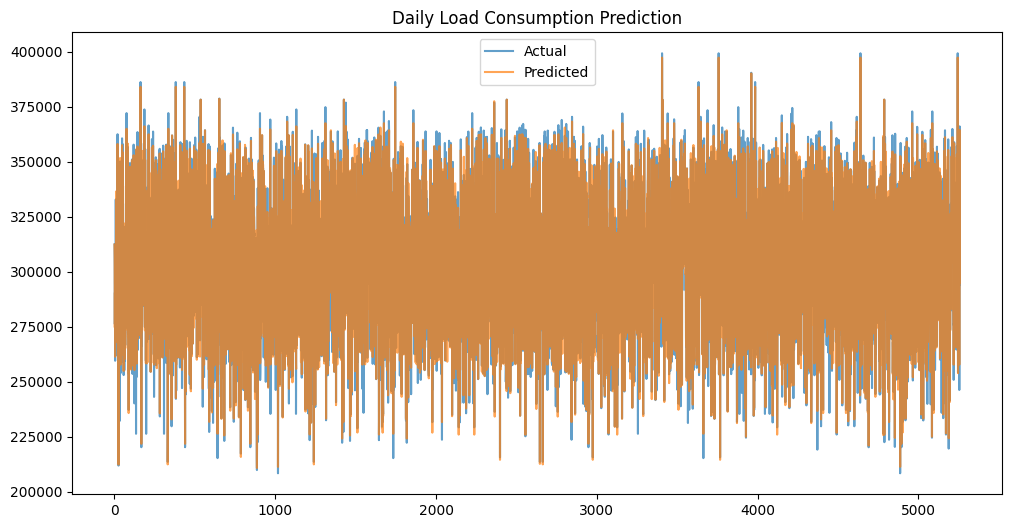

In [53]:
# Visualization
plt.figure(figsize=(12,6))
plt.plot(y_test_daily.values, label="Actual", alpha=0.7)
plt.plot(y_pred_daily, label="Predicted", alpha=0.7)
plt.legend()
plt.title("Daily Load Consumption Prediction")
plt.show()


Epoch 1/50
1314/1314 [==============================] - 44s 32ms/step - loss: 0.1434 - val_loss: 0.1223
Epoch 2/50
1314/1314 [==============================] - 41s 31ms/step - loss: 0.0816 - val_loss: 0.0725
Epoch 3/50
1314/1314 [==============================] - 42s 32ms/step - loss: 0.0679 - val_loss: 0.0719
Epoch 4/50
1314/1314 [==============================] - 42s 32ms/step - loss: 0.0601 - val_loss: 0.0643
Epoch 5/50
1314/1314 [==============================] - 43s 33ms/step - loss: 0.0522 - val_loss: 0.0437
Epoch 6/50
1314/1314 [==============================] - 49s 37ms/step - loss: 0.0463 - val_loss: 0.0392
Epoch 7/50
1314/1314 [==============================] - 59s 45ms/step - loss: 0.0419 - val_loss: 0.0399
Epoch 8/50
1314/1314 [==============================] - 59s 45ms/step - loss: 0.0380 - val_loss: 0.0396
Epoch 9/50
1314/1314 [==============================] - 56s 43ms/step - loss: 0.0366 - val_loss: 0.0391
Epoch 10/50
1314/1314 [==============================] - 58s 44m

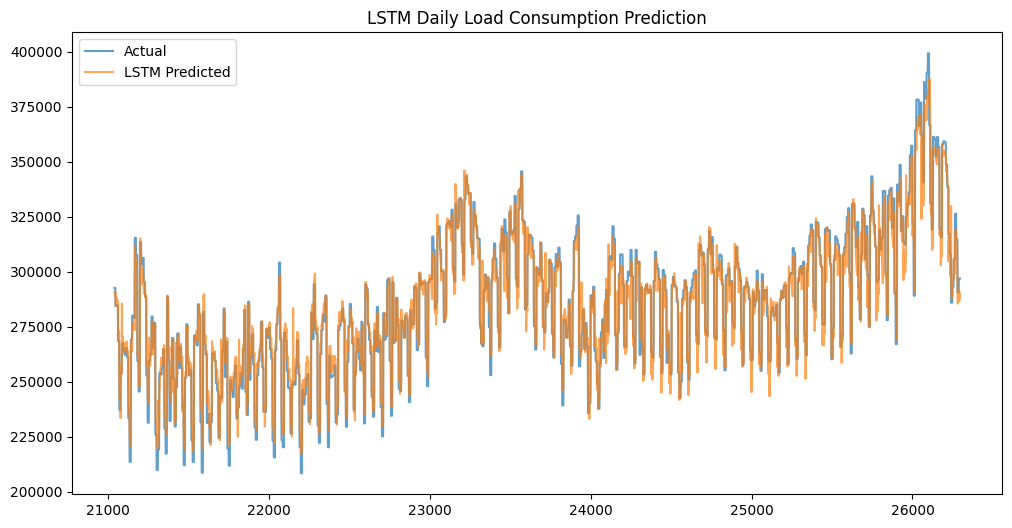

In [63]:
# Define LSTM Data Preparation Function
def prepare_lstm_data(data, target_column, lookback=30):
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data.iloc[i-lookback:i].values)
        y.append(data.iloc[i][target_column])
    return np.array(X), np.array(y)

# Select Features and Target
daily_features = daily_data.drop(columns=["loadConsumption"])
daily_target = "loadConsumption"

# Scale features
scaler_features = StandardScaler()
daily_features_scaled = scaler_features.fit_transform(daily_features)

# Scale target separately
scaler_target = StandardScaler()
daily_target_scaled = scaler_target.fit_transform(daily_data[["loadConsumption"]])

# Combine features and target into a DataFrame
daily_scaled_df = pd.DataFrame(daily_features_scaled, index=daily_data.index, columns=daily_features.columns)
daily_scaled_df["loadConsumption"] = daily_target_scaled  # Add target back

# Prepare LSTM Data
lookback = 30  # Use past 30 days to predict next day
X_lstm, y_lstm = prepare_lstm_data(daily_scaled_df, "loadConsumption", lookback)

# Split Data into Train and Test
split_index = int(0.8 * len(X_lstm))
X_train_lstm, X_test_lstm = X_lstm[:split_index], X_lstm[split_index:]
y_train_lstm, y_test_lstm = y_lstm[:split_index], y_lstm[split_index:]

# Define LSTM Model
model_lstm = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(lookback, X_lstm.shape[2])),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

# Compile Model
model_lstm.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train Model
model_lstm.fit(X_train_lstm, y_train_lstm, epochs=50, batch_size=16, validation_data=(X_test_lstm, y_test_lstm))

# Predict
y_pred_lstm = model_lstm.predict(X_test_lstm)

# Rescale Predictions
y_pred_lstm = scaler_target.inverse_transform(y_pred_lstm.reshape(-1, 1))
y_test_lstm = scaler_target.inverse_transform(y_test_lstm.reshape(-1, 1))

# Evaluate Model
print("LSTM Model Performance:")
print(f"MAE: {mean_absolute_error(y_test_lstm, y_pred_lstm)}, MSE: {mean_squared_error(y_test_lstm, y_pred_lstm)}, R^2: {r2_score(y_test_lstm, y_pred_lstm)}, MAPE: {np.mean(np.abs((y_test_lstm - y_pred_lstm) / y_test_lstm)) * 100}")

# Visualization
plt.figure(figsize=(12,6))
plt.plot(daily_data.index[-len(y_test_lstm):], y_test_lstm, label="Actual", alpha=0.7)
plt.plot(daily_data.index[-len(y_test_lstm):], y_pred_lstm, label="LSTM Predicted", alpha=0.7)
plt.legend()
plt.title("LSTM Daily Load Consumption Prediction")
plt.show()
